In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv") #, "Malfunction_dataset_SONATA")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,name,class,dataset,type,Label
0,0.369422,0.078324,0.000444,0.009978,0.724212,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.453125,0.025104,0.000232,0.009977,0.045600,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,0.343750,0.000896,0.000248,0.009981,0.009991,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,0.328125,0.008395,0.000234,0.009978,0.047617,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.375000,0.038187,0.000241,0.009978,0.036785,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...
1735835,0.187500,0.000000,0.000248,0.020620,0.020620,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735836,0.265625,0.000000,0.000235,0.013305,0.013305,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735837,0.312500,0.000000,0.000242,0.013092,0.013092,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735838,0.265625,0.000000,0.000435,0.012329,0.012329,FreeDrivingData_20171231_Spark,Spark,Survival,none,0


In [3]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [4]:
# from sklearn.preprocessing import StandardScaler, RobustScaler

# X_train_original = df.copy()

# feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

# for col in feature_columns:
#     scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
#     df.loc[:, df.columns == col] = scaler.transform(df.loc[:, df.columns == col])

# display(df)

In [5]:
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the name of the dataset
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [6]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		128216		55098
Attack		128216		55098


In [7]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

Deep Neural Network

In [18]:
import keras
from keras import layers
# from tensorflow import keras
# from keras import layers

dnn = keras.models.Sequential(
    [
        keras.Input(shape=(len(X_train.columns),), name="input"),
        layers.Dense(7, activation='relu', name="layer_1"),
        layers.Dense(13, activation='relu', name="layer_2"),
        layers.Dense(23, activation='relu', name="layer_3"),
        layers.Dense(1, activation='sigmoid', name="output")
    ]
)



dnn.compile(
    optimizer="adam",  # Optimizer rmsprop
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.FalseNegatives()],
)

from pp_tools import scale_dataset
X_train_original = X_train.copy()
scale_dataset(X_train)
scale_dataset(X_test)

val_percent = int(len(y_train) * 0.1)
X_val = X_train.sample(val_percent, random_state=0)
y_val = y_train.loc[X_val.index]
X_train = X_train.loc[~X_train.index.isin(X_val)]
y_train = y_train.loc[~y_train.index.isin(X_val)]

dnn.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
)

# results = dnn.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

Epoch 1/10
2565/2565 [==============================] - 3s 1ms/step - loss: 0.3388 - binary_accuracy: 0.8380 - recall_1: 0.8712 - false_negatives_1: 16515.0000 - val_loss: 0.2709 - val_binary_accuracy: 0.8847 - val_recall_1: 0.9332 - val_false_negatives_1: 857.0000
Epoch 2/10
2565/2565 [==============================] - 3s 992us/step - loss: 0.2556 - binary_accuracy: 0.8854 - recall_1: 0.9386 - false_negatives_1: 7876.0000 - val_loss: 0.2362 - val_binary_accuracy: 0.8970 - val_recall_1: 0.9518 - val_false_negatives_1: 619.0000
Epoch 3/10
2565/2565 [==============================] - 3s 982us/step - loss: 0.2242 - binary_accuracy: 0.9023 - recall_1: 0.9478 - false_negatives_1: 6687.0000 - val_loss: 0.2039 - val_binary_accuracy: 0.9112 - val_recall_1: 0.9606 - val_false_negatives_1: 506.0000
Epoch 4/10
2565/2565 [==============================] - 3s 975us/step - loss: 0.1802 - binary_accuracy: 0.9291 - recall_1: 0.9570 - false_negatives_1: 5513.0000 - val_loss: 0.1385 - val_binary_accurac

In [19]:
pred_train = np.round(dnn.predict(X_train))

f1_scores = f1_score(y_train, pred_train, average='weighted')
print("Training F1:  %0.4f (+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

pred_test = np.round(dnn.predict(X_test))

f1_scores = f1_score(y_test, pred_test, average='weighted')
print("Testing F1:  %0.4f (+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred_test)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1:  0.9852 (+/- 0.0000)
Testing F1:  0.7860 (+/- 0.0000)
Kappa score:  0.5873(+/- 0.0000)


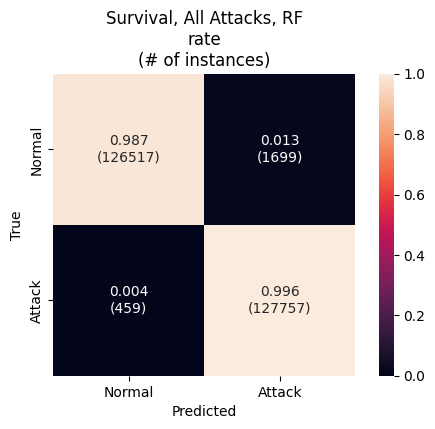

In [10]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_train, pred_train, "Survival, All Attacks, RF\nrate\n(# of instances)")

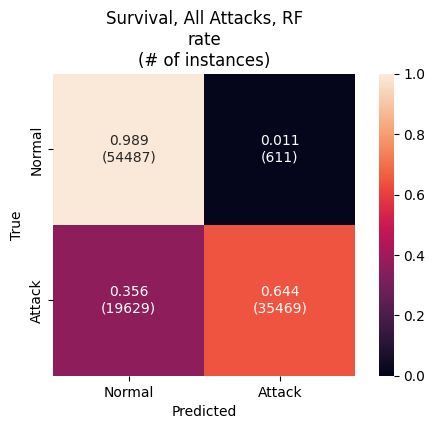

In [11]:
plot_confusion_matrix(y_test, pred_test, "Survival, All Attacks, RF\nrate\n(# of instances)")

In [12]:
import shap

exp = shap.KernelExplainer(dnn, data=X_train.sample(100, random_state=1))
print(exp.expected_value)

[0.47187201]


In [13]:
from shap_tools import *

X_exp = X_train.sample(min(len(X_train), 600), random_state=0)
y_exp = y_train[X_exp.index]
X_exp_original = X_train_original.loc[X_exp.index]


# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
# assert np.abs(exp.model.predict(X_exp) - dnn.predict_proba(X_exp)).max() < 1e-4


shap_all = get_explanation(exp, X_exp)

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

100%|██████████| 600/600 [00:18<00:00, 32.49it/s]


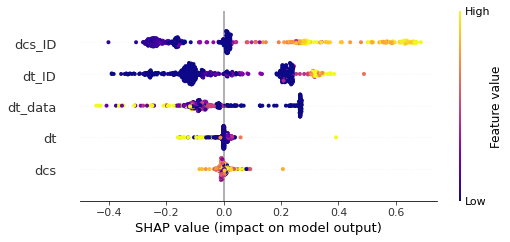

In [14]:
plot_beeswarm(shap_all)

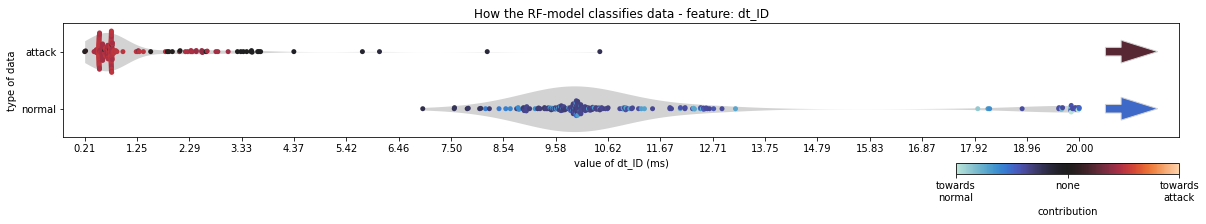

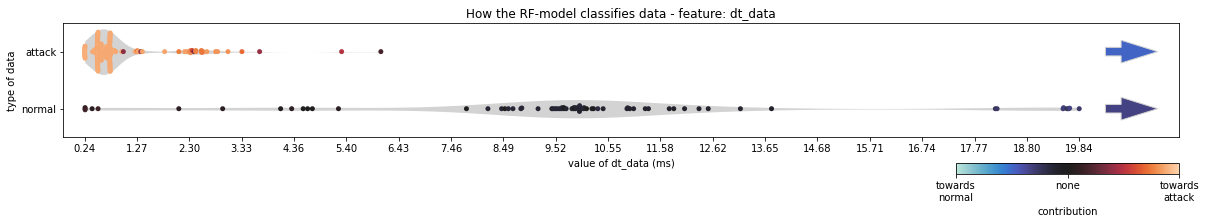

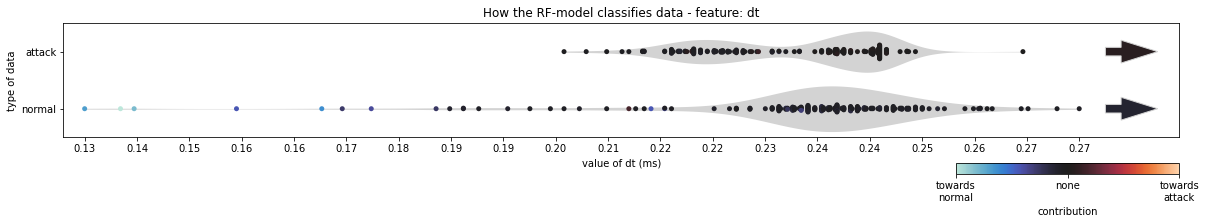

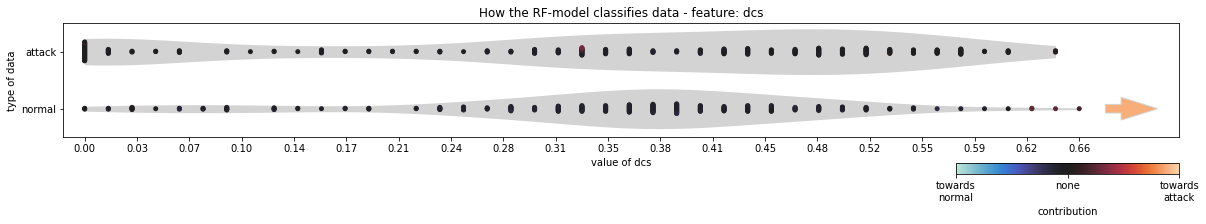

7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


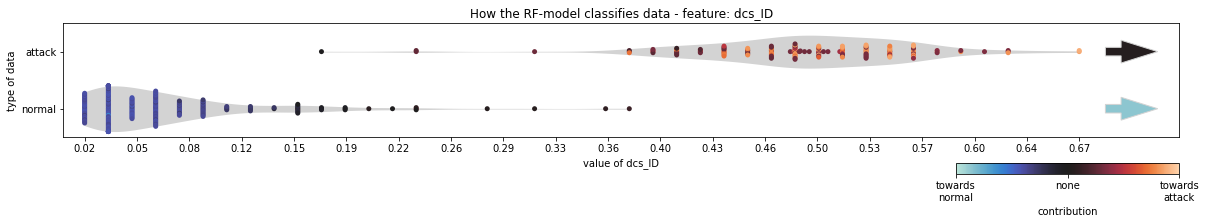

In [17]:
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", trim=(0, 0.02), scale=1000)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", trim=(0, 0.02), scale=1000)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", trim=(0, 0.0003), scale=1000, y_squish=20)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", trim=(-1, 0.7), y_squish=25)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", trim=(0, 1), y_squish=10)

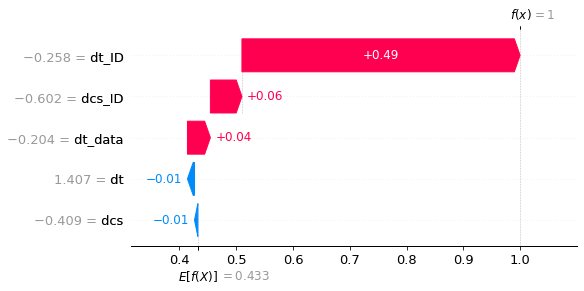

In [16]:
plot_waterfall(shap_all, 0)

In [17]:
plot_force(shap_all[0])

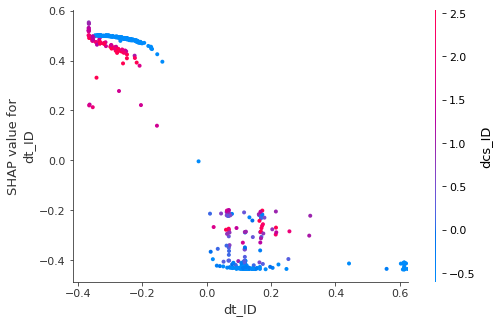

In [18]:
plot_dependence(shap_all, "dt_ID", "dcs_ID", xmax="percentile(99)")

In [19]:
dnn_layer_1 = keras.Model(inputs=dnn.input, outputs=dnn.get_layer("layer_3").output)

dnn_layer_1.predict(X_train)

array([[0.        , 2.0680475 , 0.        , ..., 0.        , 2.3630352 ,
        2.243791  ],
       [0.        , 1.7100167 , 0.        , ..., 0.        , 1.809918  ,
        1.7536744 ],
       [0.17535664, 1.4493308 , 0.        , ..., 0.        , 1.5298315 ,
        1.5848781 ],
       ...,
       [2.3730376 , 0.11246863, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.5577636 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.6439602 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [20]:
exp_layer_1 = shap.KernelExplainer(dnn_layer_1, data=X_train.sample(100, random_state=1))

In [21]:
shap_all_layer_1 = get_explanation(exp_layer_1, X_train, 100)

TypeError: get_explanation() takes 2 positional arguments but 3 were given

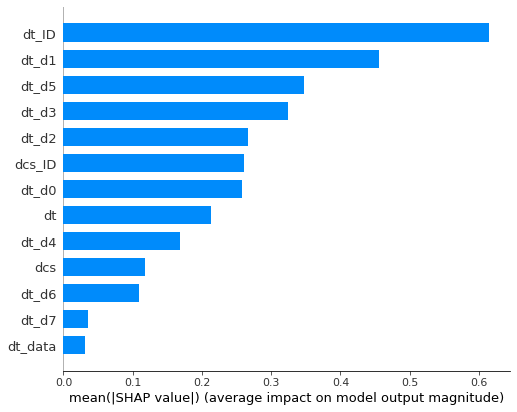

In [ ]:
# print(shap_all_layer_1)
shap.summary_plot(shap_all_layer_1, X_test, plot_type="bar")